In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [3]:
cd '/Users/jbud/Desktop/Galvanize/repos/Capstone-2'

/Users/jbud/Desktop/Galvanize/repos/Capstone-2


In [28]:
# %load src/main.py
'''
Ideas : 

questions:

A little concerned about the data - seem to show negative trend in scatter matrix - should i trim off data with very little/ no new cases?
Implement ARIMA?
Use data from countries that have covid contained (Have data for south Korea - use that data to help train the data?)

Use just CO data or specialize in specific region of US?

Use this on cases as opposed to new cases?

'''
import pandas as pd
import datetime
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

class reg_model(object):
    def __init__(self, X, y, log_trans_y = False):
        self.X = X
        self.y = y if log_trans_y == False else np.log(y + 1)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y)
        self.error_metric = None

    def lin_reg(self):
        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def log_reg(self):
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def ridge_reg(self, alpha= 0.5):
        def optimize_alpha(alpha_list):
            pass
        self.model = Ridge(alpha = alpha)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rss'

    def rand_forest(self, n_trees = 50):
        '''
        Upon inspection of the model over time, the number of new cases shows a period of exponential growth, then linear growth where the new cases levels off. Then a random forest model can be applied. A Y-transform should be applied on the data. 
        '''
        if n_trees == 'optimize':
            max_trees = 100
            n = np.arange(1, max_trees + 1, 1)
            error = []
            for each in n:
                self.model = RandomForestRegressor(n_estimators = each)
                self.model.fit(self.X_train, self.y_train)
                self.error_metric = 'rmse'
                error.append(self.evaluate_model())
            #plt.plot(n, error)
            n_trees = n[error.index(min(error))]
        self.model = RandomForestRegressor(n_estimators = n_trees)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def evaluate_model(self):
        self.y_hat = self.model.predict(self.X_test)
        self.predicted_vals_df = pd.DataFrame(self.y_test)
        self.predicted_vals_df['y_hat'] = self.y_hat
        self.predicted_vals_df.sort_index(inplace = True)
        if self.error_metric == 'rmse':
            rmse = np.sqrt(mean_squared_error(self.y_test, self.y_hat))
            return rmse
        elif self.error_metric == 'rss':
            rss = np.mean((self.y_test - self.y_hat)**2)
            return rss
    
    def forecast_vals(self, to_forecast_df):
        self.forecasted = self.model.predict(to_forecast_df)
        return self.forecasted
    
    def plot_model(self):
        fig, ax = plt.subplots(figsize = (10,6))
        if self.X_test.iloc[:, 0].shape != self.y_test.shape:
            self.X_test = self.X_test.loc[:,0]
        ax.scatter(self.X_test, self.y_test, c = 'blue', label = "Test Data")
        ax.scatter(self.X_test, self.y_hat, c = 'green', label = 'Predicted Data')
        ax.legend()
        fig.show()

def clean_data(df, datetime_col = None):
    clean_df = df.copy()
    if datetime_col != None:
        clean_df[datetime_col] = pd.to_datetime(clean_df[datetime_col])
    return clean_df

def load_and_clean_data():
    '''
    Sets up and generates dataframe for analysis
    '''

    #Import and clean covid data (Cases in 2020)
    covid_raw_df = pd.read_csv('data/covid-19-data/us.csv')
    covid_df = clean_data(covid_raw_df, datetime_col='date')
    covid_df['New_Cases'] = covid_df['cases'].diff()

    # To get daily death and ratio:
    # covid_df = calc_row_diff(covid_df, colname='deaths',
    #                          added_colname='daily_death')
    # covid_df['death/case_ratio'] = covid_df['daily_death'] / \
    #     covid_df['New_Cases']
    # covid_df['death/case_ratio'] = covid_df['death/case_ratio'].fillna(0)

    #Begin loading features that may have something to do with the fluctuation of the virus

    '''
    Mobility Data - From Google
    #The baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020
    https://www.google.com/covid19/mobility/index.html?hl=en
    '''

    mobility_raw_df = pd.read_csv(
        'data/Global_Mobility_Report.csv', low_memory=False)
    mobility_raw_df.fillna('None', inplace=True)
    US_mobility_raw_df = mobility_raw_df[(mobility_raw_df['country_region'] == 'United States') & (
        mobility_raw_df['sub_region_1'] == 'None')]
    mobility_df = clean_data(US_mobility_raw_df, datetime_col='date')
    mobility_df.reset_index(inplace=True)
    mobility_df.drop(['index', 'country_region_code',
                      'country_region', 'sub_region_1', 'sub_region_2'], axis=1, inplace=True)
    mobility_df.rename(columns=lambda x: x.replace(
        '_percent_change_from_baseline', ''), inplace=True)
    num_cols = ['retail_and_recreation', 'grocery_and_pharmacy',
                'parks', 'transit_stations', 'workplaces', 'residential']
    mobility_df[num_cols] = mobility_df[num_cols].apply(pd.to_numeric)

    #Convert to percent of normal
    mobility_df.iloc[:, 1:] = mobility_df.iloc[:,
                                               1:].apply(lambda x: (x + 100)/100)

    '''
    Transp data - From Apple
    The CSV file and charts on this site show a relative volume of directions requests per country/region, sub-region or city compared to a baseline volume on January 13th, 2020. We define our day as midnight-to-midnight, Pacific time.
    https://www.apple.com/covid19/mobility 
    '''
    transp_raw_df = pd.read_csv('data/applemobilitytrends-2020-05-09.csv')
    transp_df = transp_raw_df[(
        transp_raw_df['region'] == 'United States')].copy()
    transp_df.drop(['geo_type', 'region', 'alternative_name'],
                   axis=1, inplace=True)
    transp_df.set_index('transportation_type', inplace=True)
    transp_df = (transp_df.T) / 100  # Convert to percentage of normal
    transp_df.columns = ['driving', 'transit', 'walking']
    transp_df.reset_index(inplace=True)
    transp_df.rename(columns={'index': 'date'}, inplace=True)
    transp_df['date'] = pd.to_datetime(transp_df['date'])

    mobility_df = mobility_df.merge(transp_df, how='inner', on='date')
    covid_df = mobility_df.merge(covid_df, how='inner', on='date')
    covid_df.drop(['cases', 'deaths'], axis=1, inplace=True)
    
    #Converts date into days elapsed since outbreak- some functions don't work with datetime objects
    dates = covid_df['date']
    covid_df['date'] = covid_df.index
    covid_df.rename(columns={'date': 'days_elapsed'}, inplace=True)
    return covid_df

if __name__ == '__main__':
    covid_df = load_and_clean_data()
    y = covid_df.pop('New_Cases')
    X = covid_df
    # ridge_model = reg_model(X, y)
    # ridge_model.ridge_reg()
    # ridge_model.evaluate_model()
    rf_model = reg_model(X, y, log_trans_y = True)
    rf_model.rand_forest(n_trees = 'optimize')
    rf_model.evaluate_model()

Text(0, 0.5, 'New Cases by day')

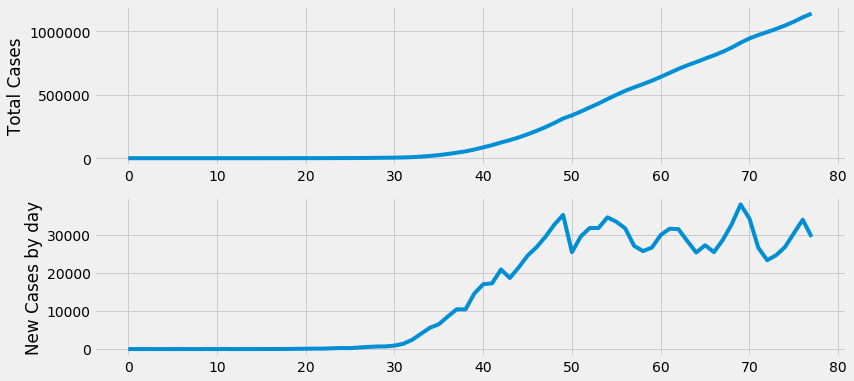

In [21]:
#DO NOT ERASE
covid_df = load_and_clean_data()
fig, axes = plt.subplots(2, 1, figsize = (12, 6))
axes[0].plot(covid_df.index, covid_df['cases'])
axes[0].set_ylabel('Total Cases')
axes[1].plot(covid_df.index, covid_df['New_Cases'])
axes[1].set_ylabel('New Cases by day')

In [8]:
rf_model.evaluate_model()

0.696593053674462

In [30]:
rf_model.predicted_vals_df

,New_Cases,y_hat
6,1.386294,1.362023
8,0.000000,0.719565
10,1.098612,1.508033
14,1.791759,1.803502
25,5.505332,5.320645
30,6.811244,6.866615
31,7.244228,7.300432
37,9.253208,9.265012
39,9.589256,9.584630
43,9.834941,10.045162


In [22]:
np.e ** (rf_model.predicted_vals_df)

,New_Cases,y_hat
0,1.0,1.565085
3,1.0,9.848596
18,37.0,35.905536
20,84.0,50.778096
21,118.0,90.332718
29,703.0,1266.858422
31,1400.0,1083.961833
35,6526.0,3222.752716
37,10438.0,9434.439570
39,14607.0,13371.218187


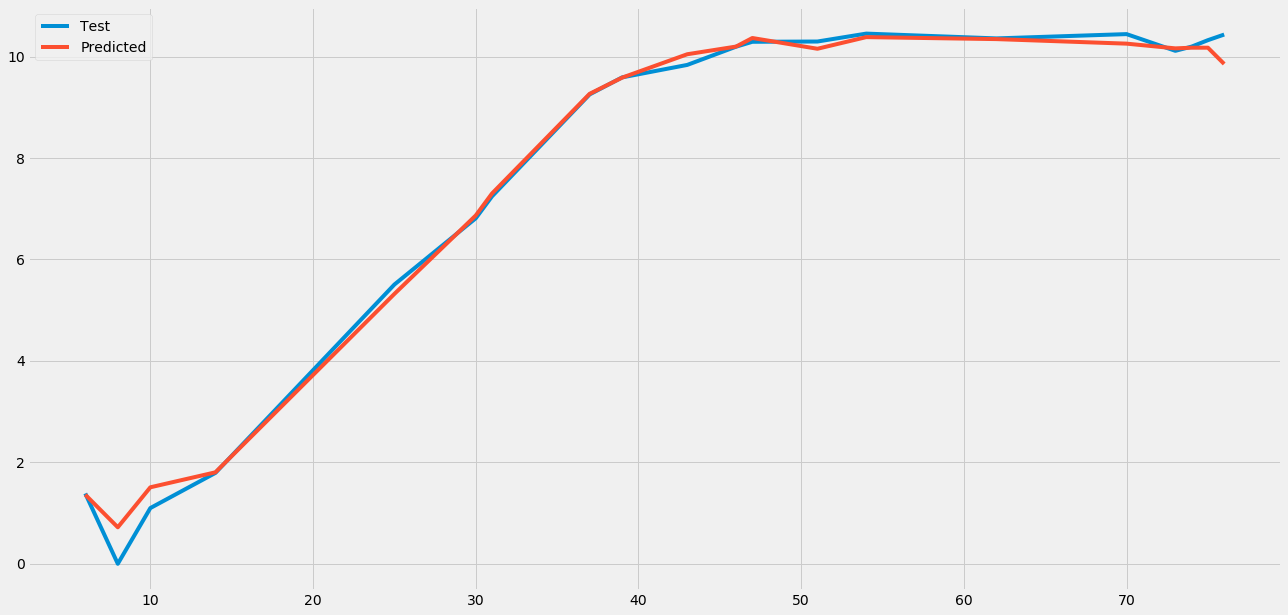

In [31]:
covid_df = load_and_clean_data()
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(rf_model.predicted_vals_df.index,rf_model.predicted_vals_df['New_Cases'], label = 'Test')
ax.plot(rf_model.predicted_vals_df.index, rf_model.predicted_vals_df['y_hat'], label = 'Predicted') #Random forest linear regression on log transform Y
ax.legend()

In [42]:
covid_df

,days_elapsed,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving,transit,walking,New_Cases
0,0,1.06,1.02,1.15,1.03,1.02,0.99,1.3251,1.0777,1.5855,0.0
1,1,1.07,1.01,1.16,1.02,1.00,0.99,1.0227,0.9163,1.1626,0.0
2,2,1.06,1.00,1.28,0.91,0.76,1.05,1.1078,1.0173,1.0752,10.0
3,3,1.00,0.99,1.06,1.01,1.00,1.01,1.0946,1.0464,1.0023,0.0
4,4,1.02,1.00,1.08,1.01,1.01,1.00,1.1085,1.0516,1.0321,0.0
...,...,...,...,...,...,...,...,...,...,...,...
73,73,0.66,0.90,1.06,0.55,0.52,1.12,0.7133,0.2732,0.5761,24652.0
74,74,0.66,0.89,0.93,0.54,0.53,1.19,0.7186,0.2684,0.5667,26790.0
75,75,0.66,0.91,0.93,0.53,0.53,1.19,0.7498,0.2666,0.5781,30414.0
76,76,0.68,0.93,1.07,0.57,0.55,1.18,0.8850,0.2924,0.6958,33975.0


In [47]:
for i in range(40, 100):
    forecast = [[i,0.1, 0.1, 0.1, 0.1, 0.1, 1.8, 1, 0.2811, 0.7129]]
    print(i, np.e ** rf_model.forecast_vals(forecast)[0])

40 19099.122360859466
41 19099.122360859466
42 19665.578642132965
43 20286.005915872967
44 20286.005915872967
45 22031.333167428016
46 22031.333167428016
47 24656.690730032413
48 24784.944617004807
49 24784.944617004807
50 24784.944617004807
51 24784.944617004807
52 24784.944617004807
53 24784.944617004807
54 24823.978810604352
55 24823.978810604352
56 24823.978810604352
57 24823.978810604352
58 24823.978810604352
59 24823.978810604352
60 24823.978810604352
61 24823.978810604352
62 24823.978810604352
63 24823.978810604352
64 24823.978810604352
65 24823.978810604352
66 24823.978810604352
67 24823.978810604352
68 24823.978810604352
69 24823.978810604352
70 24823.978810604352
71 24823.978810604352
72 24823.978810604352
73 24823.978810604352
74 24823.978810604352
75 24823.978810604352
76 24823.978810604352
77 24823.978810604352
78 24823.978810604352
79 24823.978810604352
80 24823.978810604352
81 24823.978810604352
82 24823.978810604352
83 24823.978810604352
84 24823.978810604352
85 24823.9

In [36]:
from pandas.plotting import scatter_matrix
import seaborn as sns; sns.set(style="ticks", color_codes=True)

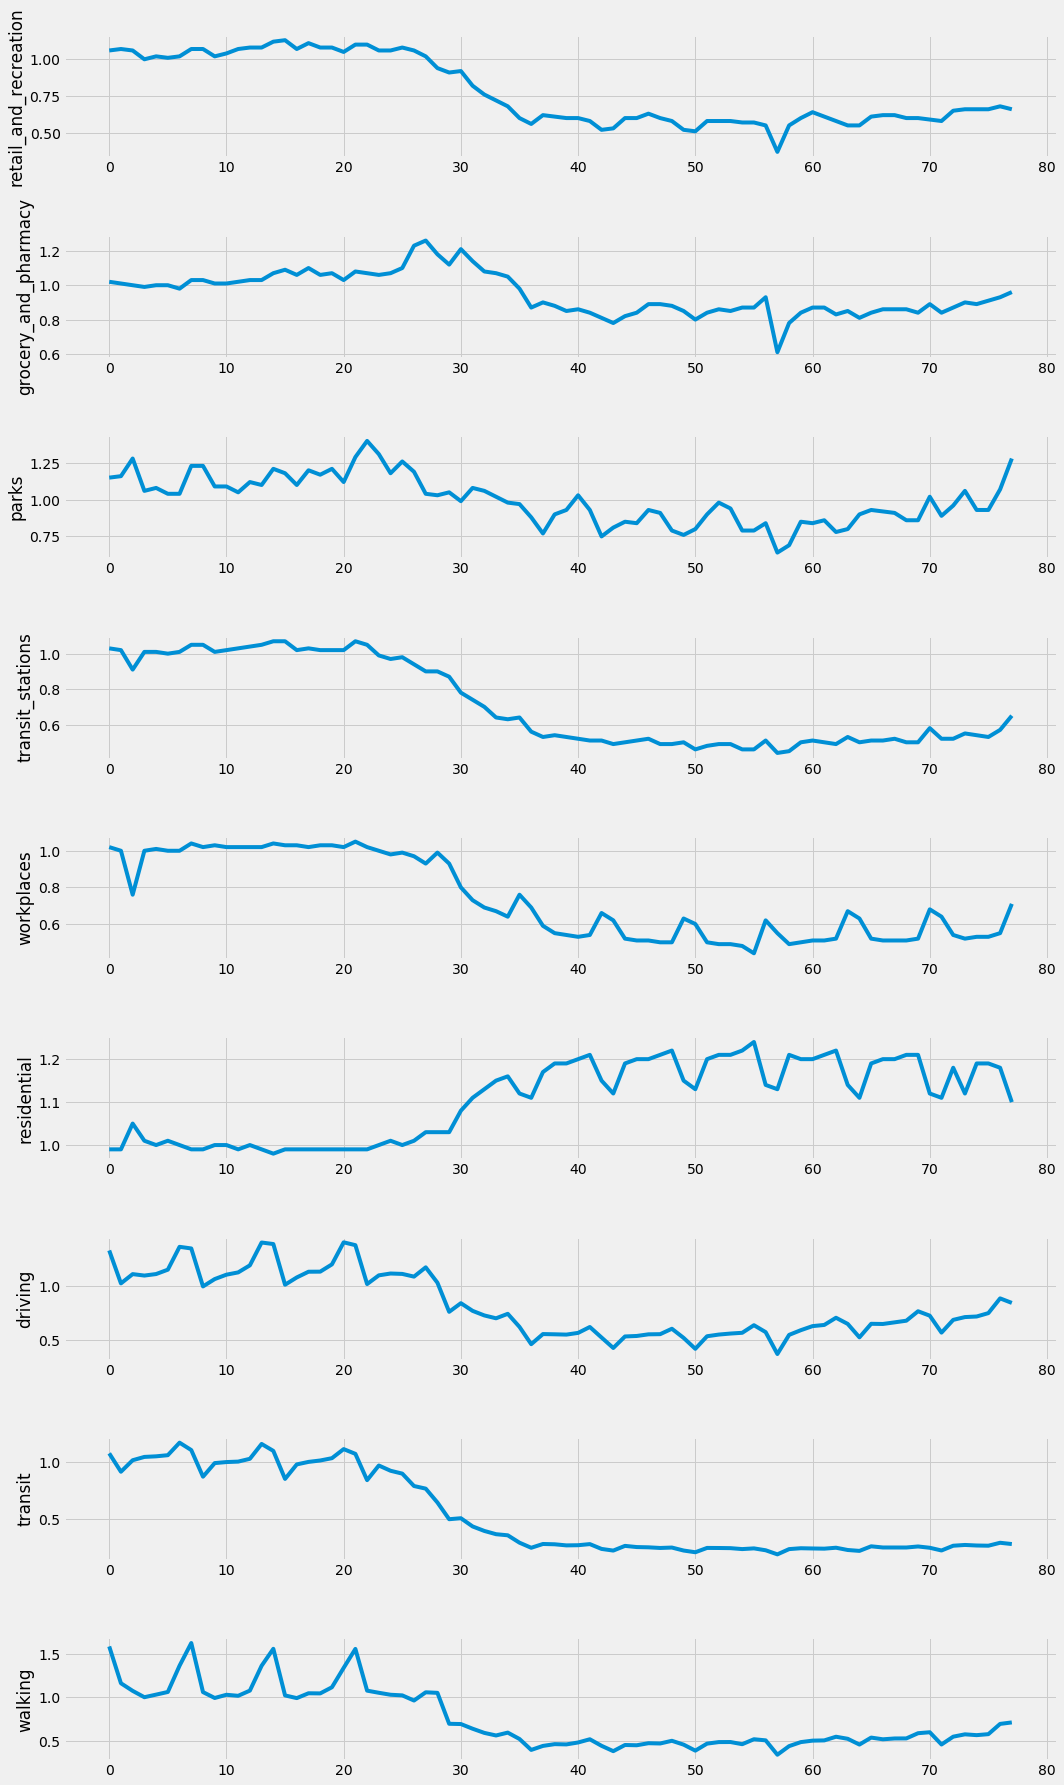

In [33]:
fix, axes = plt.subplots(9, 1, figsize = (15,25))
for ax, col in zip(axes, covid_df.columns[1:]):
    ax.plot(covid_df[col])
    ax.set_ylabel(col)
    plt.tight_layout()

In [34]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78 entries, 0 to 77
Data columns (total 11 columns):
days_elapsed             78 non-null int64
retail_and_recreation    78 non-null float64
grocery_and_pharmacy     78 non-null float64
parks                    78 non-null float64
transit_stations         78 non-null float64
workplaces               78 non-null float64
residential              78 non-null float64
driving                  78 non-null float64
transit                  78 non-null float64
walking                  78 non-null float64
New_Cases                78 non-null float64
dtypes: float64(10), int64(1)
memory usage: 7.3 KB


In [38]:
covid_df['New_Cases'] = y

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2cc247f0>,
      dtype=object)

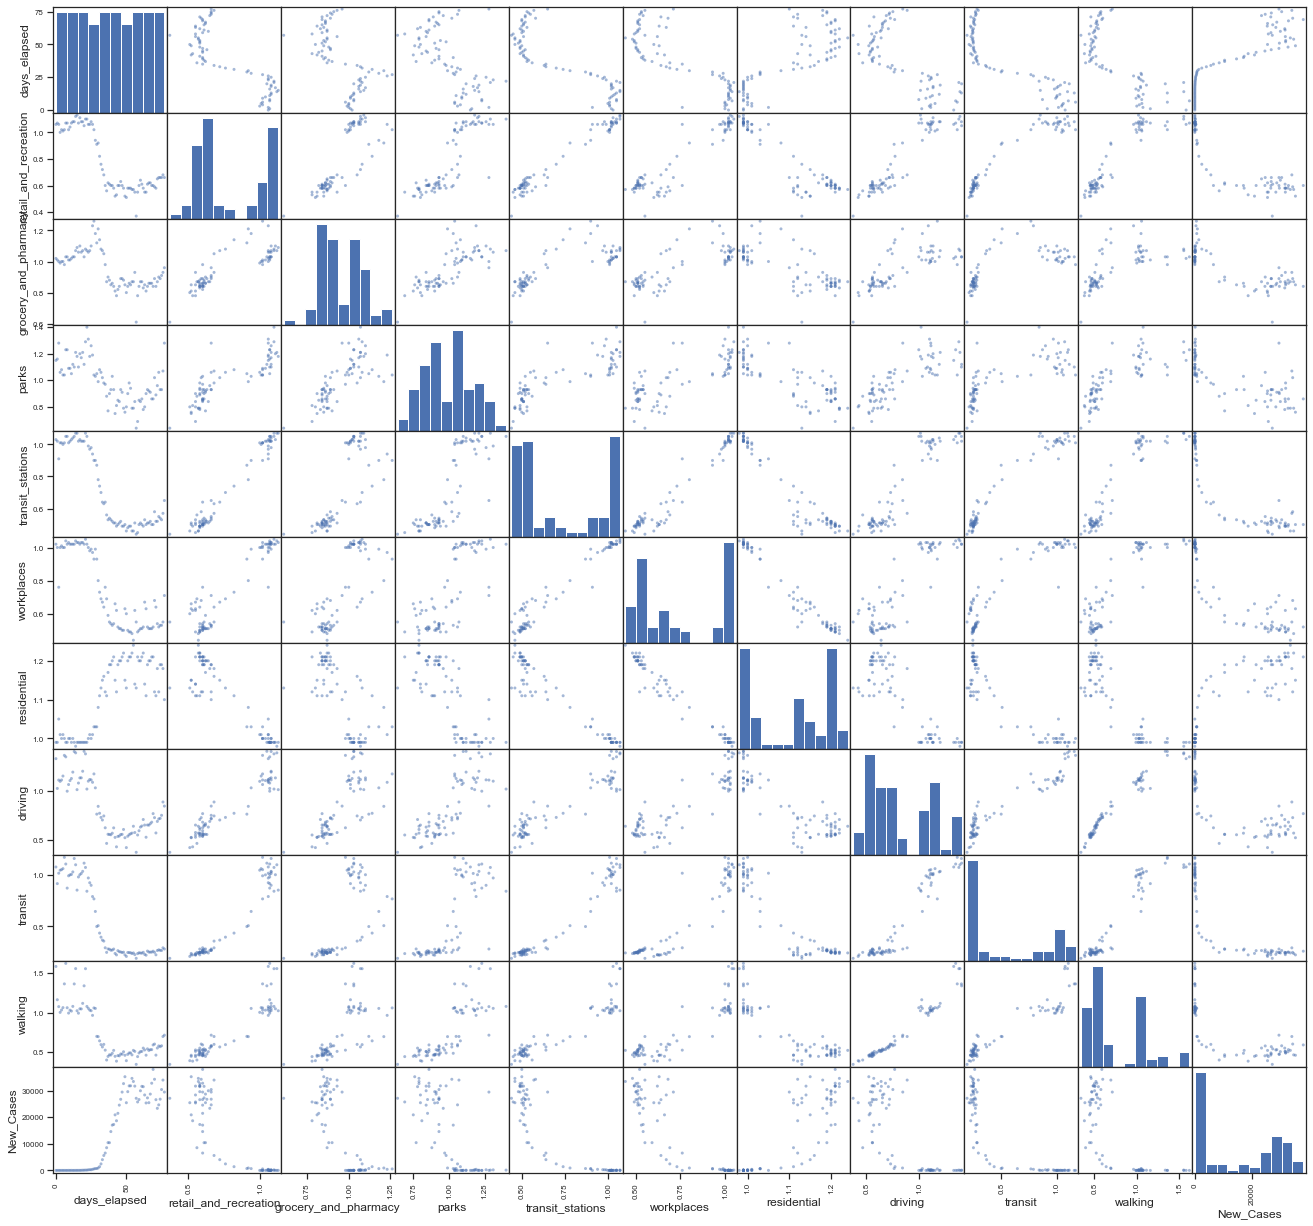

In [39]:
scatter_matrix(covid_df, figsize = (20, 20))

In [ ]:
unemployment_df = pd.read_csv('LNS14000024.csv', index_col = 0)
unemployment_df.head()
unemployment_df.index = pd.to_datetime(unemployment_df.index)

In [ ]:
plt.plot(unemployment_df)

In [ ]:
plt.style.use('ggplot')
plt.plot(covid_df['New_Cases'])
plt.xticks(rotation = 90)
plt.title('New Cases of COVID-19')
plt.savefig('Covid-19 New')

In [4]:
cd '/Users/jbud/Desktop/Galvanize/repos/Capstone-2'

/Users/jbud/Desktop/Galvanize/repos/Capstone-2


In [5]:
'''
If we use number of cases as the target variable:

'''


import pandas as pd
import datetime
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

class reg_model(object):
    def __init__(self, X, y, log_trans_y = False):
        self.X = X
        self.y = y if log_trans_y == False else np.log(y + 1)

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y)
        self.error_metric = None

    def lin_reg(self):
        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def log_reg(self):
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def ridge_reg(self, alpha= 0.5):
        def optimize_alpha(alpha_list):
            pass
        self.model = Ridge(alpha = alpha)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rss'

    def rand_forest(self, n_trees = 50):
        '''
        Upon inspection of the model over time, the number of new cases shows a period of exponential growth, then linear growth where the new cases levels off. Then a random forest model can be applied. A Y-transform is applied on the data. 
        '''
        if n_trees == 'optimize':
            max_trees = 100
            n = np.arange(1, max_trees + 1, 1)
            error = []
            for each in n:
                self.model = RandomForestRegressor(n_estimators = each)
                self.model.fit(self.X_train, self.y_train)
                self.error_metric = 'rmse'
                error.append(self.evaluate_model())
            #plt.plot(n, error)
            n_trees = n[error.index(min(error))]
        self.model = RandomForestRegressor(n_estimators = n_trees)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def evaluate_model(self):
        self.y_hat = self.model.predict(self.X_test)
        self.predicted_vals_df = pd.DataFrame(self.y_test)
        self.predicted_vals_df['y_hat'] = self.y_hat
        self.predicted_vals_df.sort_index(inplace = True)
        if self.error_metric == 'rmse':
            rmse = np.sqrt(mean_squared_error(self.y_test, self.y_hat))
            return rmse
        elif self.error_metric == 'rss':
            rss = np.mean((self.y_test - self.y_hat)**2)
            return rss
    
    def forecast_vals(self, to_forecast_df):
        self.forecasted = self.model.predict(to_forecast_df)
        return self.forecasted
    
    def plot_model(self):
        fig, ax = plt.subplots(figsize = (10,6))
        if self.X_test.iloc[:, 0].shape != self.y_test.shape:
            self.X_test = self.X_test.loc[:,0]
        ax.scatter(self.X_test, self.y_test, c = 'blue', label = "Test Data")
        ax.scatter(self.X_test, self.y_hat, c = 'green', label = 'Predicted Data')
        ax.legend()
        fig.show()

def clean_data(df, datetime_col = None):
    clean_df = df.copy()
    if datetime_col != None:
        clean_df[datetime_col] = pd.to_datetime(clean_df[datetime_col])
    return clean_df

def calc_row_diff(df, colname = 'cases', added_colname = 'New_Cases'):
    '''
    Input: Pandas DataFrame, String of column names
    Output: Dataframe with added column calculating the difference in each row of colname
    '''
    prev = df.iloc[0][colname]
    new = [prev]
    for each in df[colname][1:]:
        new.append(each - prev)
        prev = each
    df[added_colname] = new
    return df

def load_and_clean_data():
    '''
    Sets up and generates dataframe for analysis
    '''

    #Import and clean covid data (Cases in 2020)
    covid_raw_df = pd.read_csv('data/covid-19-data/us.csv')
    covid_df = clean_data(covid_raw_df, datetime_col='date')
    covid_df = calc_row_diff(covid_df)

    # To get daily death and ratio:
    # covid_df = calc_row_diff(covid_df, colname='deaths',
    #                          added_colname='daily_death')
    # covid_df['death/case_ratio'] = covid_df['daily_death'] / \
    #     covid_df['New_Cases']
    # covid_df['death/case_ratio'] = covid_df['death/case_ratio'].fillna(0)

    #Begin loading features that may have something to do with the fluctuation of the virus

    '''
    Mobility Data - From Google
    #The baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020
    '''

    mobility_raw_df = pd.read_csv(
        'data/Global_Mobility_Report.csv', low_memory=False)
    mobility_raw_df.fillna('None', inplace=True)
    US_mobility_raw_df = mobility_raw_df[(mobility_raw_df['country_region'] == 'United States') & (
        mobility_raw_df['sub_region_1'] == 'None')]
    mobility_df = clean_data(US_mobility_raw_df, datetime_col='date')
    mobility_df.reset_index(inplace=True)
    mobility_df.drop(['index', 'country_region_code',
                      'country_region', 'sub_region_1', 'sub_region_2'], axis=1, inplace=True)
    mobility_df.rename(columns=lambda x: x.replace(
        '_percent_change_from_baseline', ''), inplace=True)
    num_cols = ['retail_and_recreation', 'grocery_and_pharmacy',
                'parks', 'transit_stations', 'workplaces', 'residential']
    mobility_df[num_cols] = mobility_df[num_cols].apply(pd.to_numeric)

    #Convert to percent of normal
    mobility_df.iloc[:, 1:] = mobility_df.iloc[:,
                                               1:].apply(lambda x: (x + 100)/100)

    '''
    Transp data - From Apple
    The CSV file and charts on this site show a relative volume of directions requests per country/region, sub-region or city compared to a baseline volume on January 13th, 2020. We define our day as midnight-to-midnight, Pacific time.
    '''
    transp_raw_df = pd.read_csv('data/applemobilitytrends-2020-05-09.csv')
    transp_df = transp_raw_df[(
        transp_raw_df['region'] == 'United States')].copy()
    transp_df.drop(['geo_type', 'region', 'alternative_name'],
                   axis=1, inplace=True)
    transp_df.set_index('transportation_type', inplace=True)
    transp_df = (transp_df.T) / 100  # Convert to percentage of normal
    transp_df.columns = ['driving', 'transit', 'walking']
    transp_df.reset_index(inplace=True)
    transp_df.rename(columns={'index': 'date'}, inplace=True)
    transp_df['date'] = pd.to_datetime(transp_df['date'])

    mobility_df = mobility_df.merge(transp_df, how='inner', on='date')
    covid_df = mobility_df.merge(covid_df, how='inner', on='date')
    covid_df.drop(['deaths', 'New_Cases'], axis=1, inplace=True)
    
    #Converts date into days elapsed since outbreak- some functions don't work with datetime objects
    dates = covid_df['date']
    covid_df['date'] = covid_df.index
    covid_df.rename(columns={'date': 'days_elapsed'}, inplace=True)
    return covid_df

if __name__ == '__main__':
    covid_df = load_and_clean_data()
    y = covid_df.pop('cases')
    X = covid_df
    # ridge_model = reg_model(X, y)
    # ridge_model.ridge_reg()
    # ridge_model.evaluate_model()
    rf_model = reg_model(X, y, log_trans_y = True)
    rf_model.rand_forest(n_trees = 'optimize')
    rf_model.evaluate_model()


    # log_reg_model = reg_model(np.array(covid_df.index).reshape(-1, 1),
    #                 covid_df['New_Cases'])
    # log_reg_model.log_reg()
    # print(log_reg_model.evaluate_model())
    # log_reg_model.plot_model()


In [ ]:
covid_df['target'] = y

In [6]:
covid_df

,days_elapsed,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving,transit,walking
0,0,1.06,1.02,1.15,1.03,1.02,0.99,1.3251,1.0777,1.5855
1,1,1.07,1.01,1.16,1.02,1.00,0.99,1.0227,0.9163,1.1626
2,2,1.06,1.00,1.28,0.91,0.76,1.05,1.1078,1.0173,1.0752
3,3,1.00,0.99,1.06,1.01,1.00,1.01,1.0946,1.0464,1.0023
4,4,1.02,1.00,1.08,1.01,1.01,1.00,1.1085,1.0516,1.0321
...,...,...,...,...,...,...,...,...,...,...
73,73,0.66,0.90,1.06,0.55,0.52,1.12,0.7133,0.2732,0.5761
74,74,0.66,0.89,0.93,0.54,0.53,1.19,0.7186,0.2684,0.5667
75,75,0.66,0.91,0.93,0.53,0.53,1.19,0.7498,0.2666,0.5781
76,76,0.68,0.93,1.07,0.57,0.55,1.18,0.8850,0.2924,0.6958


In [16]:
for i in range(78, 100):
    forecast = [[i, 1, 1, 1, 1, 1, 1, 0.8434, 0.2811, 0.7129]]
    print(i, np.e ** rf_model.forecast_vals(forecast)[0])

78 37957.729756814406
79 37957.729756814406
80 37957.729756814406
81 37957.729756814406
82 37957.729756814406
83 37957.729756814406
84 37957.729756814406
85 37957.729756814406
86 37957.729756814406
87 37957.729756814406
88 37957.729756814406
89 37957.729756814406
90 37957.729756814406
91 37957.729756814406
92 37957.729756814406
93 37957.729756814406
94 37957.729756814406
95 37957.729756814406
96 37957.729756814406
97 37957.729756814406
98 37957.729756814406
99 37957.729756814406


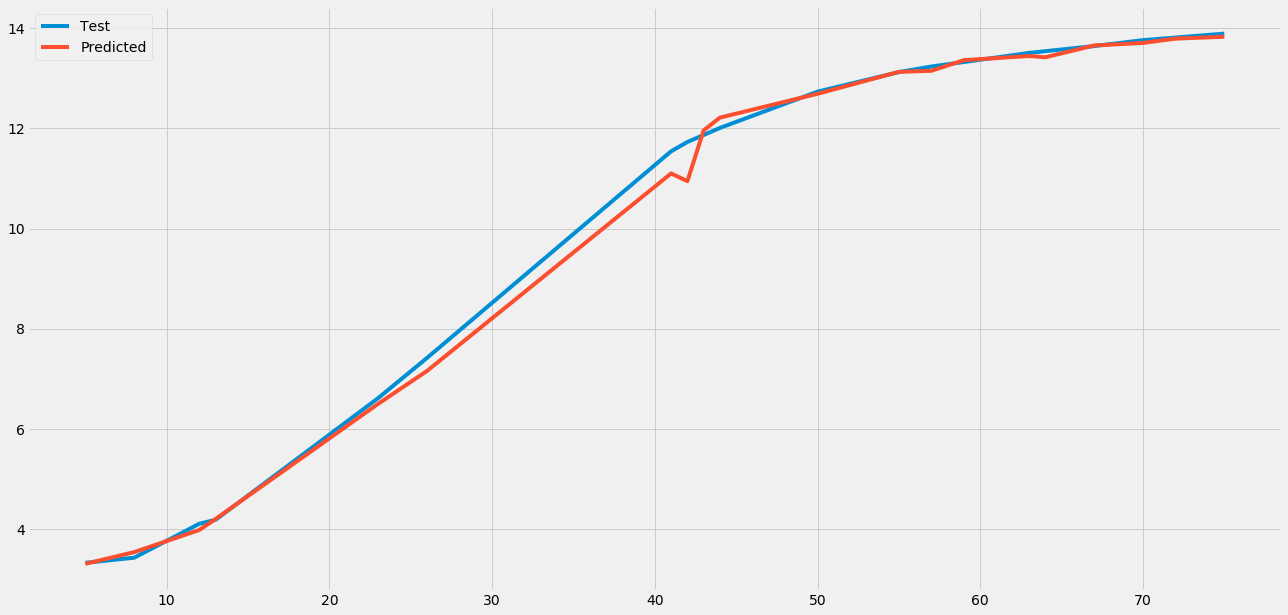

In [10]:
#Full Dataset
covid_df = load_and_clean_data()
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(rf_model.predicted_vals_df.index,rf_model.predicted_vals_df['cases'], label = 'Test')
ax.plot(rf_model.predicted_vals_df.index, rf_model.predicted_vals_df['y_hat'], label = 'Predicted') #Random forest linear regression on log transform Y
ax.legend()

In [ ]:
plt.plot(np.log(covid_raw_df['cases']))